# A Linear Model for Bulldozers

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV

In [3]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [7]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/raw')

In [8]:
df, y, mapper = proc_df(df_raw, 'SalePrice', max_n_cat=10, do_scale=True)

In [9]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df)-n_valid
y_train, y_valid = split_vals(y, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [10]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

# Linear regression for Bulldozers

## Data scaling

In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SalesID,401125.0,3.147483e-15,1.000001,-0.858580,-0.551518,-0.308344,0.355322,4.855369
MachineID,401125.0,2.895953e-15,1.000001,-2.761738,-0.292989,0.139657,0.567277,2.876309
ModelID,401125.0,-1.300773e-13,1.000001,-1.102854,-0.583548,-0.367372,0.294819,4.871330
datasource,401125.0,-6.855920e-13,1.000001,-1.524823,-0.297450,-0.297450,0.148868,4.165727
auctioneerID,401125.0,-1.064768e-13,1.000001,-0.381738,-0.321407,-0.261075,-0.140412,5.591096
YearMade,401125.0,6.797770e-16,1.000001,-3.081446,0.294188,0.328458,0.345593,0.390145
MachineHoursCurrentMeter,401125.0,8.635210e-14,1.000001,-0.074396,-0.074396,-0.074396,-0.074396,150.038499
fiModelDesc,401125.0,1.672709e+03,1263.331163,0.000000,630.000000,1394.000000,2291.000000,4998.000000
fiBaseModel,401125.0,5.581654e+02,469.310266,0.000000,205.000000,405.000000,703.000000,1949.000000
fiSecondaryDesc,401125.0,3.568504e+01,38.228243,-1.000000,-1.000000,28.000000,56.000000,174.000000


In [15]:
X_train, X_valid = split_vals(df, n_trn)

In [16]:
m = LinearRegression().fit(X_train, y_train)
m.score(X_valid, y_valid)

0.30002804818761653

In [17]:
m.score(X_train, y_train)

0.60876706316140083

In [18]:
preds = m.predict(X_valid)

In [19]:
rmse(preds, y_valid)

0.6260605407515345

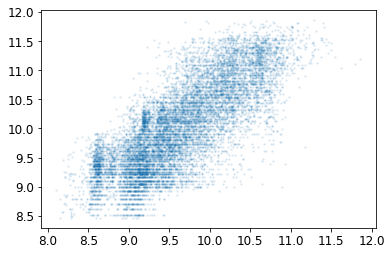

In [20]:
plt.scatter(preds, y_valid, alpha=0.1, s=2);

## Feature selection from RF

In [47]:
keep_cols = list(np.load('tmp/keep_cols.npy'))
', '.join(keep_cols)

'YearMade, Coupler_System, ProductSize, fiProductClassDesc, Hydraulics_Flow, ModelID, saleElapsed, fiSecondaryDesc, Enclosure, fiModelDesc, SalesID, fiModelDescriptor, MachineID, Hydraulics, Drive_System, ProductGroup, saleDay, state, saleWeek'

In [48]:
df_sub = df_raw[keep_cols+['SalePrice']]

In [49]:
df, y, mapper = proc_df(df_sub, 'SalePrice', max_n_cat=10, do_scale=True)

In [50]:
X_train, X_valid = split_vals(df, n_trn)

In [51]:
m = LinearRegression().fit(X_train, y_train)
m.score(X_valid, y_valid)

0.64527496352952474

In [52]:
rmse(m.predict(X_valid), y_valid)

0.4456787568129748

In [53]:
from operator import itemgetter

In [54]:
sorted(list(zip(X_valid.columns, m.coef_)), key=itemgetter(1))

[('ProductSize_Mini', -0.48393870233682168),
 ('ProductSize_Compact', -0.48388565844021314),
 ('ProductGroup_SSL', -0.4790679422655319),
 ('Drive_System_Two Wheel Drive', -0.27996939778676266),
 ('Enclosure_None or Unspecified', -0.2343602636556924),
 ('Enclosure_nan', -0.1898872119508713),
 ('Drive_System_nan', -0.17241450111081985),
 ('Enclosure_EROPS AC', -0.16470092801045877),
 ('Hydraulics_Flow_Standard', -0.1538570914605939),
 ('Enclosure_OROPS', -0.11134134868272787),
 ('MachineID', -0.083834108513150651),
 ('ProductSize_nan', -0.07885182968291625),
 ('Drive_System_Four Wheel Drive', -0.062638261741249965),
 ('Enclosure_EROPS', -0.055962482515240941),
 ('Hydraulics_Flow_nan', -0.049353907218340431),
 ('saleElapsed', -0.024346066417974401),
 ('Hydraulics_Flow_High Flow', -0.022959338611465478),
 ('saleWeek', -0.018540693085609249),
 ('Coupler_System_nan', -0.011084298593559805),
 ('Coupler_System_None or Unspecified', -0.002524241653535729),
 ('saleDay', -0.0020224632757482337),


In [55]:
m = LassoCV().fit(X_train, y_train)
m.score(X_valid, y_valid)

0.61135367991426437

In [56]:
rmse(m.predict(X_valid), y_valid)

0.46650176686783246

In [57]:
m.alpha_

0.015888143202334483

In [58]:
coefs = sorted(list(zip(X_valid.columns, m.coef_)), key=itemgetter(1))
coefs

[('ProductGroup_SSL', -0.32681235082233911),
 ('ProductSize_Mini', -0.32401456491261199),
 ('ProductSize_nan', -0.14345815840912562),
 ('Enclosure_OROPS', -0.1187234276018681),
 ('MachineID', -0.081853610727409348),
 ('saleElapsed', -0.01671063361180011),
 ('saleWeek', -0.0028843258000070962),
 ('state', -0.00040331860940888729),
 ('Hydraulics', -0.0001116937667348863),
 ('fiModelDesc', -1.04240346968906e-06),
 ('ModelID', -0.0),
 ('SalesID', -0.0),
 ('saleDay', -0.0),
 ('Coupler_System_None or Unspecified', -0.0),
 ('Coupler_System_Yes', -0.0),
 ('ProductSize_Compact', -0.0),
 ('ProductSize_Large', 0.0),
 ('ProductSize_Small', 0.0),
 ('Hydraulics_Flow_High Flow', -0.0),
 ('Hydraulics_Flow_None or Unspecified', 0.0),
 ('Hydraulics_Flow_Standard', -0.0),
 ('Hydraulics_Flow_nan', 0.0),
 ('Enclosure_EROPS', 0.0),
 ('Enclosure_EROPS AC', -0.0),
 ('Enclosure_NO ROPS', 0.0),
 ('Enclosure_None or Unspecified', -0.0),
 ('Enclosure_nan', -0.0),
 ('Drive_System_All Wheel Drive', 0.0),
 ('Drive_S

In [59]:
skip = [n for n,c in coefs if abs(c)<0.01]

In [60]:
df.drop(skip, axis=1, inplace=True)

for n,c in df.items():
    if '_' not in n: df[n+'2'] = df[n]**2

In [61]:
X_train, X_valid = split_vals(df, n_trn)

In [62]:
m = LassoCV().fit(X_train, y_train)
m.score(X_valid, y_valid)

/home/jhoward/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/jhoward/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.68272501663760088

In [63]:
rmse(m.predict(X_valid), y_valid)

0.42149645662276897

In [64]:
m.alpha_

0.00048351312659691468

In [65]:
coefs = sorted(list(zip(X_valid.columns, m.coef_)), key=itemgetter(1))
coefs

[('ProductSize_Mini', -0.73599008702672497),
 ('ProductGroup_SSL', -0.29300124873070738),
 ('ProductSize_nan', -0.28476720658869581),
 ('saleElapsed', -0.086665603838317354),
 ('MachineID', -0.073138270533239347),
 ('Enclosure_OROPS', -0.04508205078331172),
 ('saleElapsed2', -0.015019532283192851),
 ('MachineID2', 0.012036721024874904),
 ('ProductSize_Large / Medium', 0.18603699103653956),
 ('ProductSize_Medium', 0.23104117808218841),
 ('Enclosure_EROPS w AC', 0.36901650751059906),
 ('Coupler_System_nan', 0.47050786865593658),
 ('ProductGroup_MG', 0.56237710110892425),
 ('YearMade2', 1.465484650199421),
 ('YearMade', 4.1350884628471336)]